# Approach 1b: Comparing histograms with closest lapse image
Instead of comparing images directly (approach 1a), we compare the image histograms using the Kolmogorov-Smirnov test. We expect low "goodness of fit" values between the histograms for anomalous images since the appearance of an anomalous object would alter the histogram. Since color information is important (at least for daytime images), we compare the histogram of each color channel individually. Using a linear SVM, we try to classify new images as normal or anomalous.

### Advantages compared to approach 1a (pixel-wise comparison)
- less sensitive to camera movement
- less sensitive to small moving objects or dust particles
- almost not sensitive to noise
- color information is preserved

### Problems
- very sensitive to lighting changes
- loss of local information (we're only looking at the histogram)
- can easily be confused, e.g. by green or brown animals
- color information is useless at night

In [6]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

from py.PlotUtils import plot_roc_curve
from py.Dataset import Dataset
from py.ImageUtils import display_images, is_daytime

DIR = './ResizedSessions_NoBackup' # dataset directory

ds = Dataset(DIR)
session = ds.create_session("beaver_01")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 2 sessions
Session 'Beaver_01' at folder: ./ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


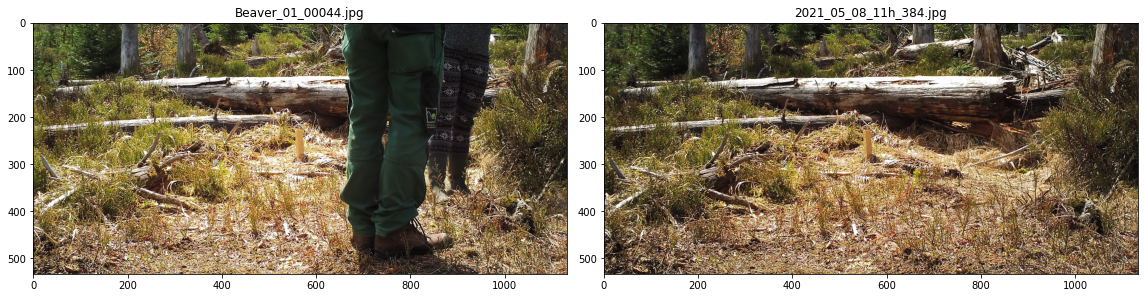

In [2]:
motion_img = session.get_random_motion_image(day_only=True)
before_img, after_img, rel = motion_img.get_closest_lapse_images()
comp_img = before_img if rel <= 0.5 else after_img
motion_arr = motion_img.read(gray=False)
comp_arr = comp_img.read(gray=False)
display_images([motion_arr, comp_arr], [motion_img.filename, comp_img.filename])

In [3]:
hists = [np.histogram(motion_arr[:,:,i], bins=range(256), density=True) for i in range(3)]
comp_hists = [np.histogram(comp_arr[:,:,i], bins=range(256), density=True) for i in range(3)]

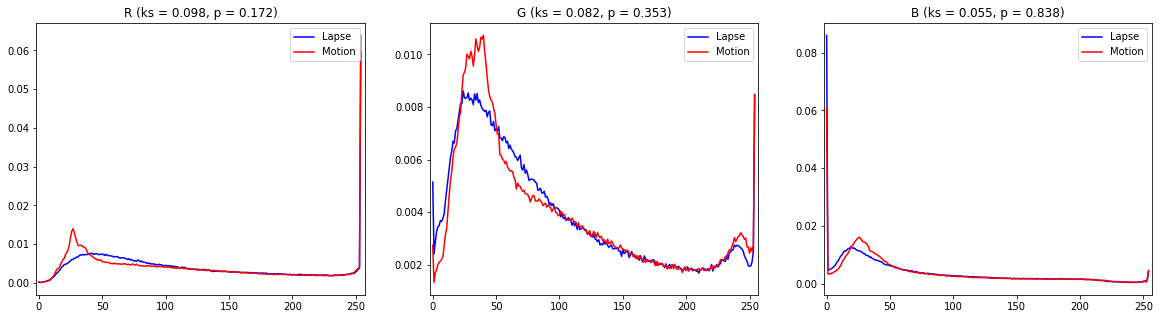

In [4]:
from scipy.stats import ks_2samp

plt.figure(figsize=(20, 5))
for channel, channel_name in enumerate(["R", "G", "B"]):
    # calculate Kolmogorov-Smirnov test
    ks, p = ks_2samp(comp_hists[channel][0], hists[channel][0])

    # plot
    plt.subplot(1, 3, channel + 1)
    plt.plot(comp_hists[channel][1][:-1], comp_hists[channel][0], color="blue", label="Lapse")
    plt.plot(hists[channel][1][:-1], hists[channel][0], color="red", label="Motion")
    plt.xlim((-2, 257))
    plt.title(f"{channel_name} (ks = {ks:.3f}, p = {p:.3f})")
    plt.legend()
plt.show()

## Complete test

In [17]:
results = []

for img in tqdm(list(session.generate_motion_images())):
    before_img, after_img, rel = img.get_closest_lapse_images()
    if rel < 0: # no lapse image found
        continue
    comp_img = before_img if rel <= 0.5 else after_img
    motion_arr = img.read(gray=False)
    comp_arr = comp_img.read(gray=False)
    motion_daytime = is_daytime(motion_arr)

    # don't compare daytime with nighttime images
    if motion_daytime != is_daytime(comp_arr):
        # choose the other closest lapse image
        comp_img = after_img if rel <= 0.5 else before_img
        comp_arr = comp_img.read(gray=False)
        assert motion_daytime == is_daytime(comp_arr)
        # if this assertion fails, a motion image was captured at daytime between two nighttime lapse images or the other way around
    assert motion_arr.dtype == "uint8" and comp_arr.dtype == "uint8"

    # Calculate histograms
    hists = [np.histogram(motion_arr[:,:,channel], bins=range(256), density=True) for channel in range(3)]
    comp_hists = [np.histogram(comp_arr[:,:,channel], bins=range(256), density=True) for channel in range(3)]

    # Compare each channel using Kolmogorov-Smirnov test
    vals = [list(ks_2samp(comp_hists[channel][0], hists[channel][0])) for channel in range(3)]
    results.append([img.filename, *vals])

  0%|          | 0/695 [00:00<?, ?it/s]

In [18]:
np.save(f"Cache_NoBackup/approach1b_{session.name}_results.npy", results)

/home/kleinsteuber/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [19]:
results = np.load(f"Cache_NoBackup/approach1b_{session.name}_results.npy", allow_pickle=True)
results

array([['Beaver_01_00134.jpg',
        list([0.1803921568627451, 0.0004837347512529537]),
        list([0.23921568627450981, 8.215743051351134e-07]),
        list([0.11764705882352941, 0.05857104535159017])],
       ['Beaver_01_00329.jpg',
        list([0.10588235294117647, 0.1146823484510564]),
        list([0.19607843137254902, 0.00010568941169931606]),
        list([0.11372549019607843, 0.07385998493202764])],
       ['Beaver_01_00167.jpg',
        list([0.13725490196078433, 0.016301855576781033]),
        list([0.13725490196078433, 0.016301855576781033]),
        list([0.13725490196078433, 0.016301855576781033])],
       ...,
       ['Beaver_01_00658.jpg',
        list([0.2901960784313726, 7.216496108235626e-10]),
        list([0.2901960784313726, 7.216496108235626e-10]),
        list([0.2901960784313726, 7.216496108235626e-10])],
       ['Beaver_01_00355.jpg',
        list([0.21568627450980393, 1.3144022142141512e-05]),
        list([0.21568627450980393, 1.3144022142141512e-05]),


In [20]:
from py.Labels import LABELS

normal = []
anomalous = []
for filename, r, g, b in results:
    vals = [r[0], g[0], b[0], r[1], g[1], b[1]] # p values of all channels
    img_nr = int(filename[10:-4])
    if img_nr > LABELS[session.name]["max"]:
        continue
    elif img_nr in LABELS[session.name]["normal"]:
        normal.append(vals)
    else:
        anomalous.append(vals)
normal = np.array(normal)
anomalous = np.array(anomalous)

### 3d plot of ks values

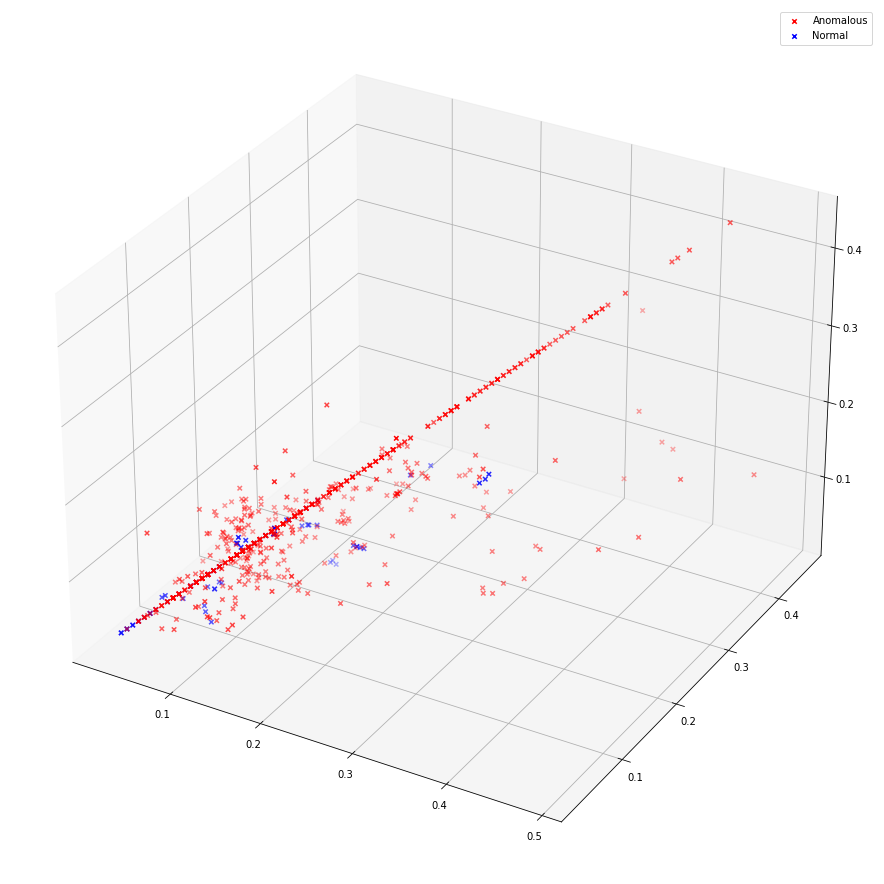

In [21]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(projection="3d")
ax.scatter(anomalous[:,0], anomalous[:,1], anomalous[:,2], label="Anomalous", color="red", marker="x")
ax.scatter(normal[:,0], normal[:,1], normal[:,2], label="Normal", color="blue", marker="x")
# ax.xscale("log")
# ax.yscale("log")
plt.legend()

plt.show()

### 3d plot of p values

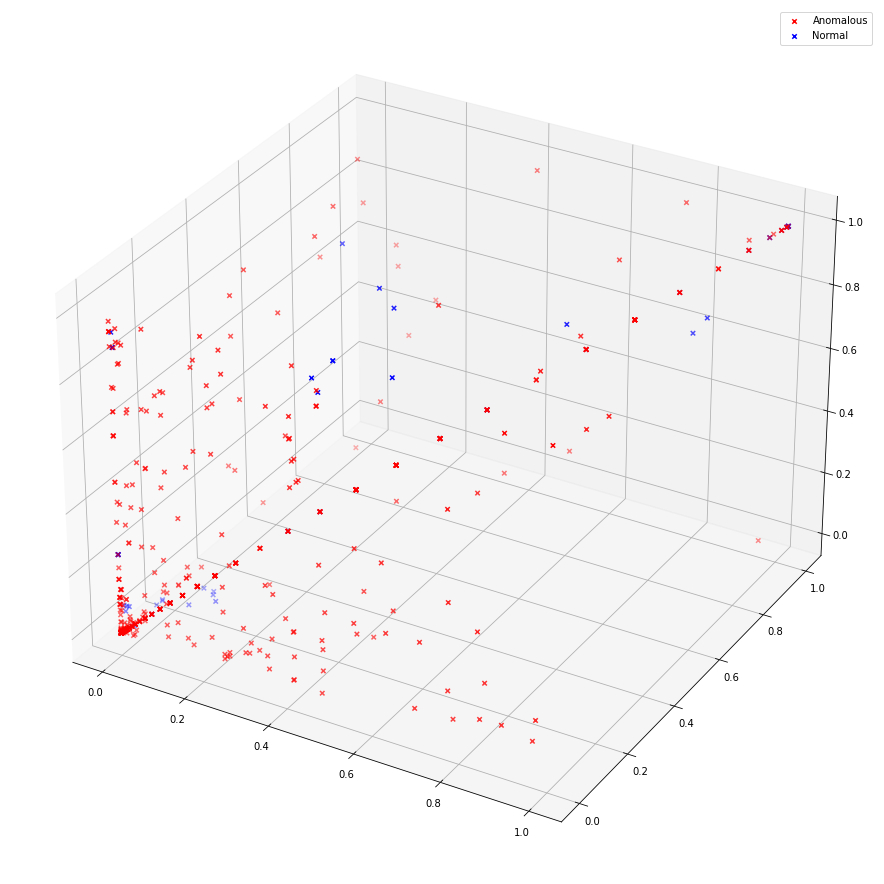

In [22]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(projection="3d")
ax.scatter(anomalous[:,3], anomalous[:,4], anomalous[:,5], label="Anomalous", color="red", marker="x")
ax.scatter(normal[:,3], normal[:,4], normal[:,5], label="Normal", color="blue", marker="x")
# ax.xscale("log")
# ax.yscale("log")
plt.legend()

plt.show()

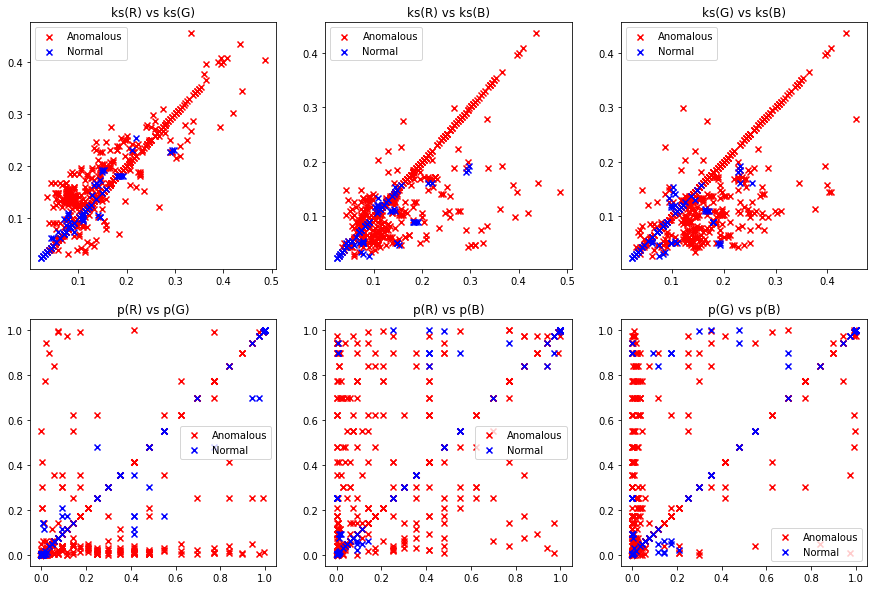

In [23]:
fig = plt.figure(figsize=(15,10))
channels = ["ks(R)", "ks(G)", "ks(B)", "p(R)", "p(G)", "p(B)"]
i = 0
for c1, c2 in [(0, 1), (0, 2), (1, 2), (3, 4), (3, 5), (4, 5)]:
    i += 1
    plt.subplot(2, 3, i)
    plt.scatter(anomalous[:,c1], anomalous[:,c2], label="Anomalous", color="red", marker="x")
    plt.scatter(normal[:,c1], normal[:,c2], label="Normal", color="blue", marker="x")
    plt.legend()
    plt.title(f"{channels[c1]} vs {channels[c2]}")
plt.show()

In [59]:
normal_means = 1 - np.mean(normal[:,3:6], axis=1)
anomalous_means = 1 - np.mean(anomalous[:,3:6], axis=1)
print(np.mean(normal_means), np.mean(anomalous_means))

0.627884741971111 0.8073281330931875


In [60]:
y_anom = np.array(anomalous_means).reshape(-1, 1)

y_norm = np.array(normal_means).reshape(-1, 1)

X = np.concatenate([y_norm, y_anom])
print(X.shape)
y = np.concatenate([-np.ones((y_norm.shape[0])), np.ones((y_anom.shape[0]))])
print(y.shape)

(695, 1)
(695,)


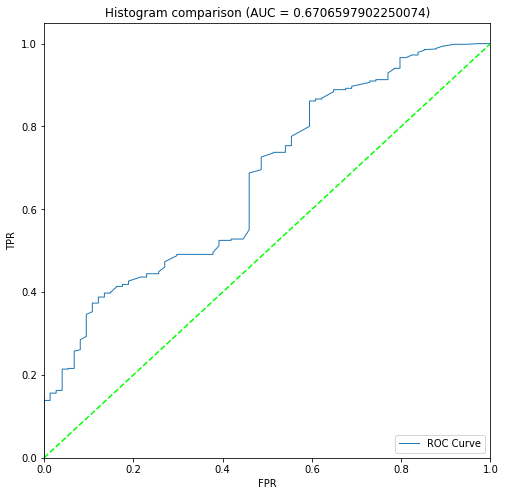

In [61]:
fpr, tpr, thresholds, auc_score = plot_roc_curve(y, X[:,0], f"Histogram comparison", savefile=f"plots/approach1b/roc_curves/{session.name}_pmean")